# An example of many-to-one (sequence classification)

Original experiment from [Hochreiter & Schmidhuber (1997)](www.bioinf.jku.at/publications/older/2604.pdf).

The goal is to classify sequences.
Elements and targets are represented locally (input vectors with only one non-zero bit).
The sequence starts with an `B`, ends with a `E` (the “trigger symbol”), and otherwise consists of randomly chosen symbols from the set `{a, b, c, d}` except for two elements at positions `t1` and `t2` that are either `X` or `Y`.
For the `DifficultyLevel.HARD` case, the sequence length is randomly chosen between `100` and `110`, `t1` is randomly chosen between `10` and `20`, and `t2` is randomly chosen between `50` and `60`.
There are `4` sequence classes `Q`, `R`, `S`, and `U`, which depend on the temporal order of `X` and `Y`.

The rules are:

```
X, X -> Q,
X, Y -> R,
Y, X -> S,
Y, Y -> U.
```

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import six

## 1. Dataset


In [ ]:
def pad_sequences(sequences, maxlen=None, dtype='int32',
                  padding='pre', truncating='pre', value=0.):
    if not hasattr(sequences, '__len__'):
        raise ValueError('`sequences` must be iterable.')
    lengths = []
    for x in sequences:
        if not hasattr(x, '__len__'):
            raise ValueError('`sequences` must be a list of iterables. '
                             'Found non-iterable: ' + str(x))
        lengths.append(len(x))

    num_samples = len(sequences)
    if maxlen is None:
        maxlen = np.max(lengths)

    # take the sample shape from the first non empty sequence
    # checking for consistency in the main loop below.
    sample_shape = tuple()
    for s in sequences:
        if len(s) > 0:
            sample_shape = np.asarray(s).shape[1:]
            break

    is_dtype_str = np.issubdtype(dtype, np.str_) or np.issubdtype(dtype, np.unicode_)
    if isinstance(value, six.string_types) and dtype != object and not is_dtype_str:
        raise ValueError("`dtype` {} is not compatible with `value`'s type: {}\n"
                         "You should set `dtype=object` for variable length strings."
                         .format(dtype, type(value)))

    x = np.full((num_samples, maxlen) + sample_shape, value, dtype=dtype)
    for idx, s in enumerate(sequences):
        if not len(s):
            continue  # empty list/array was found
        if truncating == 'pre':
            trunc = s[-maxlen:]
        elif truncating == 'post':
            trunc = s[:maxlen]
        else:
            raise ValueError('Truncating type "%s" '
                             'not understood' % truncating)

        # check `trunc` has expected shape
        trunc = np.asarray(trunc, dtype=dtype)
        if trunc.shape[1:] != sample_shape:
            raise ValueError('Shape of sample %s of sequence at position %s '
                             'is different from expected shape %s' %
                             (trunc.shape[1:], idx, sample_shape))

        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
        else:
            raise ValueError('Padding type "%s" not understood' % padding)
    return x

def to_categorical(y, num_classes=None, dtype='float32'):
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

class EchoData():

    def __init__(self, series_length=40000, batch_size=32,
                 echo_step=3, truncated_length=10, seed=None):

        self.series_length = series_length
        self.truncated_length = truncated_length
        self.n_batches = series_length//truncated_length

        self.echo_step = echo_step
        self.batch_size = batch_size
        if seed is not None:
            np.random.seed(seed)
        self.x_batch = None
        self.y_batch = None
        self.x_chunks = []
        self.y_chunks = []
        self.generate_new_series()
        self.prepare_batches()

    def __getitem__(self, index):
        if index == 0:
            self.generate_new_series()
            self.prepare_batches()
        return self.x_chunks[index], self.y_chunks[index]

    def __len__(self):
        return self.n_batches

    def generate_new_series(self):
        x = np.random.choice(
            2,
            size=(self.batch_size, self.series_length),
            p=[0.5, 0.5])
        y = np.roll(x, self.echo_step, axis=1)
        y[:, 0:self.echo_step] = 0
        self.x_batch = x
        self.y_batch = y

    def prepare_batches(self):
        x = np.expand_dims(self.x_batch, axis=-1)
        y = np.expand_dims(self.y_batch, axis=-1)
        self.x_chunks = np.split(x, self.n_batches, axis=1)
        self.y_chunks = np.split(y, self.n_batches, axis=1)

class TemporalOrderExp6aSequence():
    """
    From Hochreiter&Schmidhuber(1997):

        The goal is to classify sequences. Elements and targets are represented locally
        (input vectors with only one non-zero bit). The sequence starts with an B, ends
        with a E (the "trigger symbol") and otherwise consists of randomly chosen symbols
        from the set {a, b, c, d} except for two elements at positions t1 and t2 that are
        either X or Y . The sequence length is randomly chosen between 100 and 110, t1 is
        randomly chosen between 10 and 20, and t2 is randomly chosen between 50 and 60.
        There are 4 sequence classes Q, R, S, U which depend on the temporal order of X and Y.
        The rules are:
            X, X -> Q,
            X, Y -> R,
            Y , X -> S,
            Y , Y -> U.

    """

    def __init__(self, length_range=(100, 111), t1_range=(10, 21), t2_range=(50, 61),
                 batch_size=32, seed=None):

        self.classes = ['Q', 'R', 'S', 'U']
        self.n_classes = len(self.classes)

        self.relevant_symbols = ['X', 'Y']
        self.distraction_symbols = ['a', 'b', 'c', 'd']
        self.start_symbol = 'B'
        self.end_symbol = 'E'

        self.length_range = length_range
        self.t1_range = t1_range
        self.t2_range = t2_range
        self.batch_size = batch_size

        if seed is not None:
            np.random.seed(seed)

        all_symbols = self.relevant_symbols + self.distraction_symbols + \
                      [self.start_symbol] + [self.end_symbol]
        self.n_symbols = len(all_symbols)
        self.s_to_idx = {s: n for n, s in enumerate(all_symbols)}
        self.idx_to_s = {n: s for n, s in enumerate(all_symbols)}

        self.c_to_idx = {c: n for n, c in enumerate(self.classes)}
        self.idx_to_c = {n: c for n, c in enumerate(self.classes)}

    def generate_pair(self):
        length = np.random.randint(self.length_range[0], self.length_range[1])
        t1 = np.random.randint(self.t1_range[0], self.t1_range[1])
        t2 = np.random.randint(self.t2_range[0], self.t2_range[1])

        x = np.random.choice(self.distraction_symbols, length)
        x[0] = self.start_symbol
        x[-1] = self.end_symbol

        y = np.random.choice(self.classes)
        if y == 'Q':
            x[t1], x[t2] = self.relevant_symbols[0], self.relevant_symbols[0]
        elif y == 'R':
            x[t1], x[t2] = self.relevant_symbols[0], self.relevant_symbols[1]
        elif y == 'S':
            x[t1], x[t2] = self.relevant_symbols[1], self.relevant_symbols[0]
        else:
            x[t1], x[t2] = self.relevant_symbols[1], self.relevant_symbols[1]

        return ''.join(x), y

    # encoding/decoding single instance version

    def encode_x(self, x):
        idx_x = [self.s_to_idx[s] for s in x]
        return to_categorical(idx_x, num_classes=self.n_symbols)

    def encode_y(self, y):
        idx_y = self.c_to_idx[y]
        return to_categorical(idx_y, num_classes=self.n_classes)

    def decode_x(self, x):
        x = x[np.sum(x, axis=1) > 0]    # remove padding
        return ''.join([self.idx_to_s[pos] for pos in np.argmax(x, axis=1)])

    def decode_y(self, y):
        return self.idx_to_c[np.argmax(y)]

    # encoding/decoding batch versions

    def encode_x_batch(self, x_batch):
        return pad_sequences([self.encode_x(x) for x in x_batch],
                             maxlen=self.length_range[1])

    def encode_y_batch(self, y_batch):
        return np.array([self.encode_y(y) for y in y_batch])

    def decode_x_batch(self, x_batch):
        return [self.decode_x(x) for x in x_batch]

    def decode_y_batch(self, y_batch):
        return [self.idx_to_c[pos] for pos in np.argmax(y_batch, axis=1)]

    def __len__(self):
        """ Let's assume 1000 sequences as the size of data. """
        return int(1000. / self.batch_size)

    def __getitem__(self, index):
        batch_x, batch_y = [], []
        for _ in range(self.batch_size):
            x, y = self.generate_pair()
            batch_x.append(x)
            batch_y.append(y)
        return self.encode_x_batch(batch_x), self.encode_y_batch(batch_y)

    class DifficultyLevel:
        """ On HARD, settings are identical to the original settings from the '97 paper."""
        EASY, NORMAL, MODERATE, HARD, NIGHTMARE = range(5)

    @staticmethod
    def get_predefined_generator(difficulty_level, batch_size=32, seed=8382):
        EASY = TemporalOrderExp6aSequence.DifficultyLevel.EASY
        NORMAL = TemporalOrderExp6aSequence.DifficultyLevel.NORMAL
        MODERATE = TemporalOrderExp6aSequence.DifficultyLevel.MODERATE
        HARD = TemporalOrderExp6aSequence.DifficultyLevel.HARD

        if difficulty_level == EASY:
            length_range = (7, 9)
            t1_range = (1, 3)
            t2_range = (4, 6)
        elif difficulty_level == NORMAL:
            length_range = (30, 41)
            t1_range = (2, 6)
            t2_range = (20, 28)
        elif difficulty_level == MODERATE:
            length_range = (60, 81)
            t1_range = (10, 21)
            t2_range = (45, 55)
        elif difficulty_level == HARD:
            length_range = (100, 111)
            t1_range = (10, 21)
            t2_range = (50, 61)
        else:
            length_range = (300, 501)
            t1_range = (10, 81)
            t2_range = (250, 291)
        return TemporalOrderExp6aSequence(length_range, t1_range, t2_range,
                                          batch_size, seed)


In [ ]:
# Create a data generator

QRSU = TemporalOrderExp6aSequence

example_generator = QRSU.get_predefined_generator(
    difficulty_level=QRSU.DifficultyLevel.EASY,
    batch_size=32,
)

example_batch = example_generator[1]
print(f'The return type is a {type(example_batch)} with length {len(example_batch)}.')
print(f'The first item in the tuple is the batch of sequences with shape {example_batch[0].shape}.')
print(f'The first element in the batch of sequences is:\n {example_batch[0][0, :, :]}')
print(f'The second item in the tuple is the corresponding batch of class labels with shape {example_batch[1].shape}.')
print(f'The first element in the batch of class labels is:\n {example_batch[1][0, :]}')

The return type is a <class 'tuple'> with length 2.
The first item in the tuple is the batch of sequences with shape (32, 9, 8).
The first element in the batch of sequences is:
 [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1]]
The second item in the tuple is the corresponding batch of class labels with shape (32, 4).
The first element in the batch of class labels is:
 [1. 0. 0. 0.]


In [ ]:
# Decoding the first sequence
sequence_decoded = example_generator.decode_x(example_batch[0][0, :, :])
print(f'The sequence is: {sequence_decoded}')

# Decoding the class label of the first sequence
class_label_decoded = example_generator.decode_y(example_batch[1][0])
print(f'The class label is: {class_label_decoded}')

The sequence is: BbXcXcbE
The class label is: Q


## 2. Defining the Model

In [ ]:
import torch
import torch.nn as nn

# Set the random seed for reproducible results
torch.manual_seed(1)

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # This just calls the base class constructor
        super().__init__()
        # Neural network layers assigned as attributes of a Module subclass
        # have their parameters registered for training automatically.
        self.rnn = torch.nn.RNN(input_size, hidden_size, nonlinearity='relu', batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # The RNN also returns its hidden state but we don't use it.
        # While the RNN can also take a hidden state as input, the RNN
        # gets passed a hidden state initialized with zeros by default.
        h = self.rnn(x)[0]
        x = self.linear(h)
        return x

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = self.lstm(x)[0]
        x = self.linear(h)
        return x

    def get_states_across_time(self, x):
        h_c = None
        h_list, c_list = list(), list()
        with torch.no_grad():
            for t in range(x.size(1)):
                h_c = self.lstm(x[:, [t], :], h_c)[1]
                h_list.append(h_c[0])
                c_list.append(h_c[1])
            h = torch.cat(h_list)
            c = torch.cat(c_list)
        return h, c

## 3. Defining the Training Loop

In [ ]:
import torch.nn.utils as nn_utils

def train(model, train_data_gen, criterion, optimizer, device):
    # Set the model to training mode. This will turn on layers that would
    # otherwise behave differently during evaluation, such as dropout.
    model.train()

    # Store the number of sequences that were classified correctly
    num_correct = 0

    # Iterate over every batch of sequences. Note that the length of a data generator
    # is defined as the number of batches required to produce a total of roughly 1000
    # sequences given a batch size.
    for batch_idx in range(len(train_data_gen)):

        # Request a batch of sequences and class labels, convert them into tensors
        # of the correct type, and then send them to the appropriate device.
        data, target = train_data_gen[batch_idx]
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

        # Perform the forward pass of the model
        output = model(data)  # Step ①

        # Pick only the output corresponding to last sequence element (input is pre padded)
        output = output[:, -1, :]

        # Compute the value of the loss for this batch. For loss functions like CrossEntropyLoss,
        # the second argument is actually expected to be a tensor of class indices rather than
        # one-hot encoded class labels. One approach is to take advantage of the one-hot encoding
        # of the target and call argmax along its second dimension to create a tensor of shape
        # (batch_size) containing the index of the class label that was hot for each sequence.
        target = target.argmax(dim=1)

        loss = criterion(output, target)  # Step ②

        # Clear the gradient buffers of the optimized parameters.
        # Otherwise, gradients from the previous batch would be accumulated.

        optimizer.zero_grad()  # Step ③

        loss.backward()  # Step ④

        nn.utils.clip_grad_value_(model.parameters(), clip_value=1)

        optimizer.step()  # Step ⑤

        y_pred = output.argmax(dim=1)
        num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item()

## 4. Defining the Testing Loop

In [ ]:
def test(model, test_data_gen, criterion, device):
    # Set the model to evaluation mode. This will turn off layers that would
    # otherwise behave differently during training, such as dropout.
    model.eval()

    # Store the number of sequences that were classified correctly
    num_correct = 0

    # A context manager is used to disable gradient calculations during inference
    # to reduce memory usage, as we typically don't need the gradients at this point.
    with torch.no_grad():
        for batch_idx in range(len(test_data_gen)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            output = model(data)
            # Pick only the output corresponding to last sequence element (input is pre padded)
            output = output[:, -1, :]

            target = target.argmax(dim=1)
            loss = criterion(output, target)

            y_pred = output.argmax(dim=1)
            num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item()

## 5. Putting it All Together

In [ ]:
def train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=True):
    # Automatically determine the device that PyTorch should use for computation
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Move model to the device which will be used for train and test
    model.to(device)

    # Track the value of the loss function and model accuracy across epochs
    history_train = {'loss': [], 'acc': []}
    history_test = {'loss': [], 'acc': []}

    for epoch in range(max_epochs):
        # Run the training loop and calculate the accuracy.
        # Remember that the length of a data generator is the number of batches,
        # so we multiply it by the batch size to recover the total number of sequences.
        num_correct, loss = train(model, train_data_gen, criterion, optimizer, device)
        accuracy = float(num_correct) / (len(train_data_gen) * train_data_gen.batch_size) * 100
        history_train['loss'].append(loss)
        history_train['acc'].append(accuracy)

        # Do the same for the testing loop
        num_correct, loss = test(model, test_data_gen, criterion, device)
        accuracy = float(num_correct) / (len(test_data_gen) * test_data_gen.batch_size) * 100
        history_test['loss'].append(loss)
        history_test['acc'].append(accuracy)

        if verbose or epoch + 1 == max_epochs or epoch == 1:
            print(f'[Epoch {epoch + 1}/{max_epochs}]'
                  f" loss: {history_train['loss'][-1]:.4f}, acc: {history_train['acc'][-1]:2.2f}%"
                  f" - test_loss: {history_test['loss'][-1]:.4f}, test_acc: {history_test['acc'][-1]:2.2f}%")

    # Generate diagnostic plots for the loss and accuracy
    fig, axes = plt.subplots(ncols=2, figsize=(9, 4.5))
    for ax, metric in zip(axes, ['loss', 'acc']):
        ax.plot(history_train[metric])
        ax.plot(history_test[metric])
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.legend(['Train', 'Test'], loc='best')
    plt.show()

    return model

## 6. Model Evaluation

In [ ]:
import collections
import random

def evaluate_model(model, difficulty, seed=9001, verbose=False):
    # Define a dictionary that maps class indices to labels
    class_idx_to_label = {0: 'Q', 1: 'R', 2: 'S', 3: 'U'}

    # Create a new data generator
    data_generator = QRSU.get_predefined_generator(difficulty, seed=seed)

    # Track the number of times a class appears
    count_classes = collections.Counter()

    # Keep correctly classified and misclassified sequences, and their
    # true and predicted class labels, for diagnostic information.
    correct = []
    incorrect = []

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model.eval()

    with torch.no_grad():
        for batch_idx in range(len(data_generator)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            data_decoded = data_generator.decode_x_batch(data.cpu().numpy())
            target_decoded = data_generator.decode_y_batch(target.cpu().numpy())

            output = model(data)
            output = output[:, -1, :]

            target = target.argmax(dim=1)
            y_pred = output.argmax(dim=1)
            y_pred_decoded = [class_idx_to_label[y.item()] for y in y_pred]

            count_classes.update(target_decoded)
            for i, (truth, prediction) in enumerate(zip(target_decoded, y_pred_decoded)):
                if truth == prediction:
                    correct.append((data_decoded[i], truth, prediction))
                else:
                    incorrect.append((data_decoded[i], truth, prediction))

    num_sequences = sum(count_classes.values())
    accuracy = float(len(correct)) / num_sequences * 100
    print(f'The accuracy of the model is measured to be {accuracy:.2f}%.\n')

    # Report the accuracy by class
    for label in sorted(count_classes):
        num_correct = sum(1 for _, truth, _ in correct if truth == label)
        print(f'{label}: {num_correct} / {count_classes[label]} correct')

    # Report some random sequences for examination
    print('\nHere are some example sequences:')
    for i in range(10):
        sequence, truth, prediction = correct[random.randrange(0, 10)]
        print(f'{sequence} -> {truth} was labelled {prediction}')

    # Report misclassified sequences for investigation
    if incorrect and verbose:
        print('\nThe following sequences were misclassified:')
        for sequence, truth, prediction in incorrect:
            print(f'{sequence} -> {truth} was labelled {prediction}')
    else:
        print('\nThere were no misclassified sequences.')

## 8. Visualize LSTM
Setting difficulty to `MODERATE` and `hidden_size` to 12.

[Epoch 2/100] loss: 1.3692, acc: 24.70% - test_loss: 1.3805, test_acc: 27.12%
[Epoch 100/100] loss: 0.0002, acc: 100.00% - test_loss: 0.0002, test_acc: 100.00%


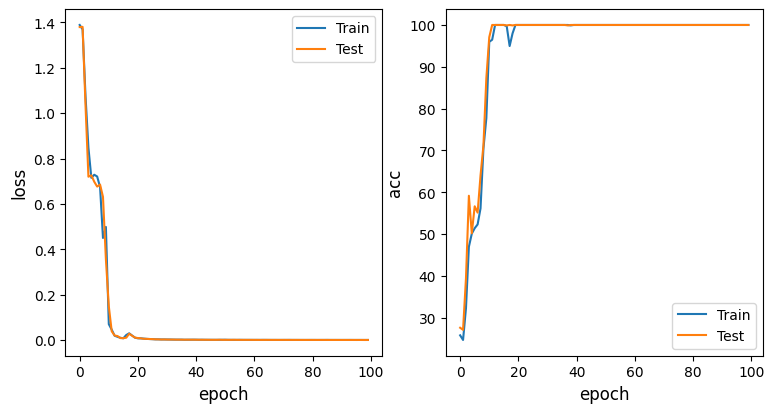

In [ ]:
# For reproducibility
torch.manual_seed(1)

import torch.nn.init as init
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        init.xavier_uniform_(m.weight)
    elif isinstance(m, torch.nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight' in name:
                init.xavier_uniform_(param)
            elif 'bias' in name:
                param.data.fill_(0)

# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.MODERATE
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 12
output_size = train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)

model.apply(init_weights)

criterion   = torch.nn.CrossEntropyLoss()
# optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
optimizer   = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)

max_epochs  = 100

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=False)

## Changes Made


*   Gradient Clipping (Section 3)
*   Xavier Initialization (Section 8)
*   AdamW Optimizer with Weight Decay (Section 8)
*   Changed Learning Rate (Section 8)